In [1]:
library(ggplot2)
library(patchwork)
library(INLA)
library(dplyr)
library(lme4)
library("ggpubr")

Loading required package: Matrix

Loading required package: sp

Loading required package: parallel

Loading required package: foreach

This is INLA_20.03.17 built 2022-09-30 01:15:10 UTC.
See www.r-inla.org/contact-us for how to get help.
To enable PARDISO sparse library; see inla.pardiso()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
rm(list = ls())

setwd("/home/yow004/Projects/NonergodicSD")

#flatfile_fname <- 'data/new_SD_PGA.csv'

flatfile_fname<- "/home/yow004/Projects/NonergodicSD/data/bayarea.groundmotion.fitted.csv"
source('R_lib/regression/inla/regression_inla_model1_unbounded_hyp.R')


Please note that rgdal will be retired by the end of 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.

rgdal: version: 1.5-32, (SVN revision 1176)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.0.4, released 2020/01/28
Path to GDAL shared files: /usr/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 6.3.1, February 10th, 2020, [PJ_VERSION: 631]
Path to PROJ shared files: /usr/share/proj
Linking to sp version:1.5-0
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading sp or rgdal.

Loading required package: spam

Spam version 2.9-1 (2022-08-07) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching pa

In [3]:
#load flatfile
utmzone = 10
df_flatfile <- read.csv(flatfile_fname)
names(df_flatfile) <- c('eqid','date','eqlat','eqlon','eqZ','mag','SD','SDD','Site','R','Vs30','Vs30class','PGA','pPGA','qPGA','sPGA','stalat','stalon')
df_flatfile$ssn <- df_flatfile$Site
df_flatfile$UTMzone <- utmzone #north california

#df_flatfile$PGA = df_flatfile$PGA/log(10)

df_flatfile<- subset(df_flatfile,mag<6)

eq<-LongLatToUTM(df_flatfile$eqlat,df_flatfile$eqlon,utmzone)
df_flatfile[,c('eqX','eqY')] <- eq[,c('X','Y')]/1000

sta<-LongLatToUTM(df_flatfile$stalat,df_flatfile$stalon,utmzone)
df_flatfile[,c('staX','staY')] <- sta[,c('X','Y')]/1000

# Preprocess Input Data
# ---------------------------
n_data <- nrow(df_flatfile)
#earthquake data
data_eq_all <- df_flatfile[,c('eqid','mag','eqX', 'eqY')]
out_unq  <- UniqueIdxInv(df_flatfile[,'eqid'])
eq_idx   <- out_unq$idx
eq_inv   <- out_unq$inv
data_eq  <- data_eq_all[eq_idx,]
X_eq     <- data_eq[,c(3,4)] #earthquake coordinates
X_eq_all <- data_eq_all[,c(3,4)]
#create earthquake ids for all records (1 to n_eq)
eq_id <- eq_inv
n_eq  <- nrow(data_eq)



#station data
data_sta_all <- df_flatfile[,c('ssn','Vs30','staX','staY')]
out_unq   <- UniqueIdxInv(df_flatfile[,'ssn'])
sta_idx   <- out_unq$idx
sta_inv   <- out_unq$inv
data_sta  <- data_sta_all[sta_idx,]
X_sta     <- data_sta[,c(3,4)] #station coordinates
X_sta_all <- data_sta_all[,c(3,4)]
#create station indices for all records (1 to n_sta)
sta_id <- sta_inv
n_sta  <- nrow(data_sta)

##
df_flatfile[,c('eq_id','sta_id')] = c(eq_id,sta_id)

In [4]:
#df <- na.omit(df_flatfile)
df <- df_flatfile
Vref = 760
y     <- df[,'PGA']
M     <- df[,'mag']
M2    <- (8.5-M)**2
R     <- df[,'R']
lnRef <- log((R**2+4.5**2)**0.5)
lnvs  <- log(df[,'Vs30']/Vref)
eqid  <- df[,'eq_id']
stid  <- df[,'sta_id']

inladata <- data.frame(M,M2,lnRef,R,lnvs,y,eqid,stid)


#event index
event<-inladata %>% group_by(eqid) %>% filter(row_number()==1)
dataM=event$M

#station index
station<-inladata %>% group_by(stid) %>% filter(row_number()==1)
dataS=station$stid



# Trugman's resutls
event2<-df_flatfile %>% group_by(eq_id) %>% filter(row_number()==1)
station2<-df_flatfile %>% group_by(sta_id) %>% filter(row_number()==1)

pred_trugman<-df_flatfile$pPGA
tot_trugman<-df_flatfile$PGA - df_flatfile$pPGA



sig<-event2$SD
dE_trugman<-event2$qPGA
dS_trugman<-station2$sPGA




	Pearson's product-moment correlation

data:  df_plot$dE_trugman and df_plot$sig
t = 64.95, df = 5294, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6506695 0.6806579
sample estimates:
      cor 
0.6659326 


`geom_smooth()` using formula 'y ~ x'



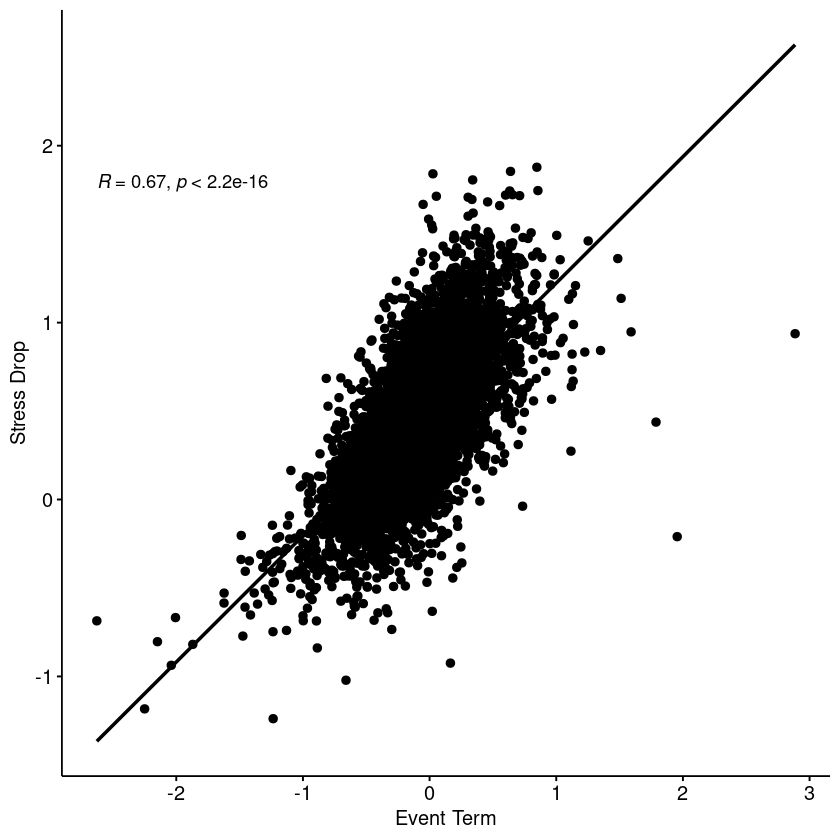

In [5]:
df_plot<-data.frame(dE_trugman,sig)
res <- cor.test(df_plot$dE_trugman, df_plot$sig, 
                method = "pearson")
res
ggscatter(df_plot, x = "dE_trugman", y = "sig", 
              add = "reg.line", conf.int = FALSE, 
              cor.coef = TRUE, cor.method = "pearson",
              xlab = "Event Term", ylab = "Stress Drop")

# use y ~ 1 + M + log(R) + dE + dW
## Trugman and Shearer, 2018

In [6]:
fit_inla0 <-inla(y ~ 1 + M + log(R) +
                  f(eqid, model="iid"), data=inladata,
                num.threads = 4,quantiles = c(0.05,0.5,0.95),
                control.predictor=list(compute=TRUE),verbose = TRUE)

summary(fit_inla0)


Call:
   c("inla(formula = y ~ 1 + M + log(R) + f(eqid, model = \"iid\"), data = 
   inladata, ", " quantiles = c(0.05, 0.5, 0.95), verbose = TRUE, 
   control.predictor = list(compute = TRUE), ", " num.threads = 4)") 
Time used:
    Pre = 0.737, Running = 219, Post = 6.69, Total = 226 
Fixed effects:
               mean    sd 0.05quant 0.5quant 0.95quant    mode kld
(Intercept) -12.031 0.057   -12.125  -12.031   -11.936 -12.031   0
M             2.740 0.023     2.703    2.740     2.777   2.740   0
log(R)       -1.482 0.004    -1.488   -1.482    -1.476  -1.482   0

Random effects:
  Name	  Model
    eqid IID model

Model hyperparameters:
                                        mean    sd 0.05quant 0.5quant 0.95quant
Precision for the Gaussian observations 1.50 0.005      1.49     1.50      1.51
Precision for eqid                      5.91 0.133      5.69     5.91      6.13
                                        mode
Precision for the Gaussian observations 1.50
Precision for eqid     

In [7]:
dB_0<-fit_inla0$summary.random$eqid
#dS_0<-fit_inla0$summary.random$stid


event_term_0<-matrix(nrow=nrow(inladata),ncol=1)
for (i in 1:nrow(inladata)){
  event_term_0[i,]<-dB_0$`0.5quant`[eq_id[i]]
}

dE_0 <- dB_0$`0.5quant`
pred_fixed_0<-fit_inla0$summary.fitted.values$mean-event_term_0

tot_0<-df_flatfile$PGA - pred_fixed_0


	Pearson's product-moment correlation

data:  df_plot$dE_0 and df_plot$sig
t = 50.467, df = 5294, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5514646 0.5878429
sample estimates:
     cor 
0.569933 


`geom_smooth()` using formula 'y ~ x'



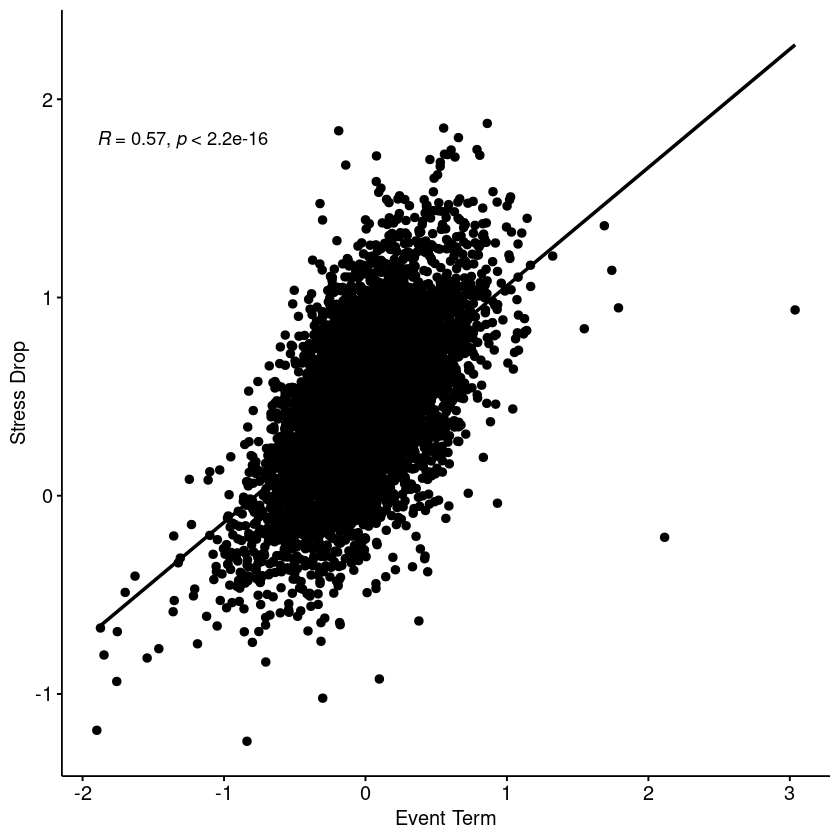

In [8]:
df_plot<-data.frame(dE_0,sig)
res <- cor.test(df_plot$dE_0, df_plot$sig, 
                method = "pearson")
res
ggscatter(df_plot, x = "dE_0", y = "sig", 
              add = "reg.line", conf.int = FALSE, 
              cor.coef = TRUE, cor.method = "pearson",
              xlab = "Event Term", ylab = "Stress Drop")

# use y ~ 1 + M + log(R) + dE + dS + dWes
## Trugman and Shearer, 2018

In [9]:
fit_inla1 <-inla(y ~ 1 + M + log(R) +
                  f(eqid, model="iid") + f(stid, model="iid"), data=inladata,
                num.threads = 4,quantiles = c(0.05,0.5,0.95),
                control.predictor=list(compute=TRUE),verbose = TRUE)

summary(fit_inla1)


Call:
   c("inla(formula = y ~ 1 + M + log(R) + f(eqid, model = \"iid\") + ", " 
   f(stid, model = \"iid\"), data = inladata, quantiles = c(0.05, ", " 
   0.5, 0.95), verbose = TRUE, control.predictor = list(compute = TRUE), 
   ", " num.threads = 4)") 
Time used:
    Pre = 0.437, Running = 99.6, Post = 6.96, Total = 107 
Fixed effects:
               mean    sd 0.05quant 0.5quant 0.95quant    mode kld
(Intercept) -11.178 0.061   -11.278  -11.178   -11.078 -11.178   0
M             2.660 0.020     2.626    2.660     2.693   2.660   0
log(R)       -1.615 0.003    -1.620   -1.615    -1.610  -1.615   0

Random effects:
  Name	  Model
    eqid IID model
   stid IID model

Model hyperparameters:
                                        mean    sd 0.05quant 0.5quant 0.95quant
Precision for the Gaussian observations 3.10 0.011      3.08     3.10      3.12
Precision for eqid                      6.97 0.150      6.72     6.98      7.21
Precision for stid                      3.75 0.330      3.

In [10]:
dB_1<-fit_inla1$summary.random$eqid
dS_1<-fit_inla1$summary.random$stid

dET_1 <- dB_1$`0.5quant`
dST_1 <- dS_1$`0.5quant`

event_term_1<-matrix(nrow=nrow(inladata),ncol=1)
station_term_1<-matrix(nrow=nrow(inladata),ncol=1)

for (i in 1:nrow(inladata)){
  event_term_1[i,]<-dET_1[eq_id[i]]
  station_term_1[i,]<-dST_1[sta_id[i]]
}

pred_fixed_1<-fit_inla1$summary.fitted.values$mean-event_term_1-station_term_1

tot_1<-df_flatfile$PGA - pred_fixed_1



	Pearson's product-moment correlation

data:  df_plot$dET_1 and df_plot$sig
t = 55.197, df = 5294, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5870078 0.6212072
sample estimates:
      cor 
0.6043859 


`geom_smooth()` using formula 'y ~ x'



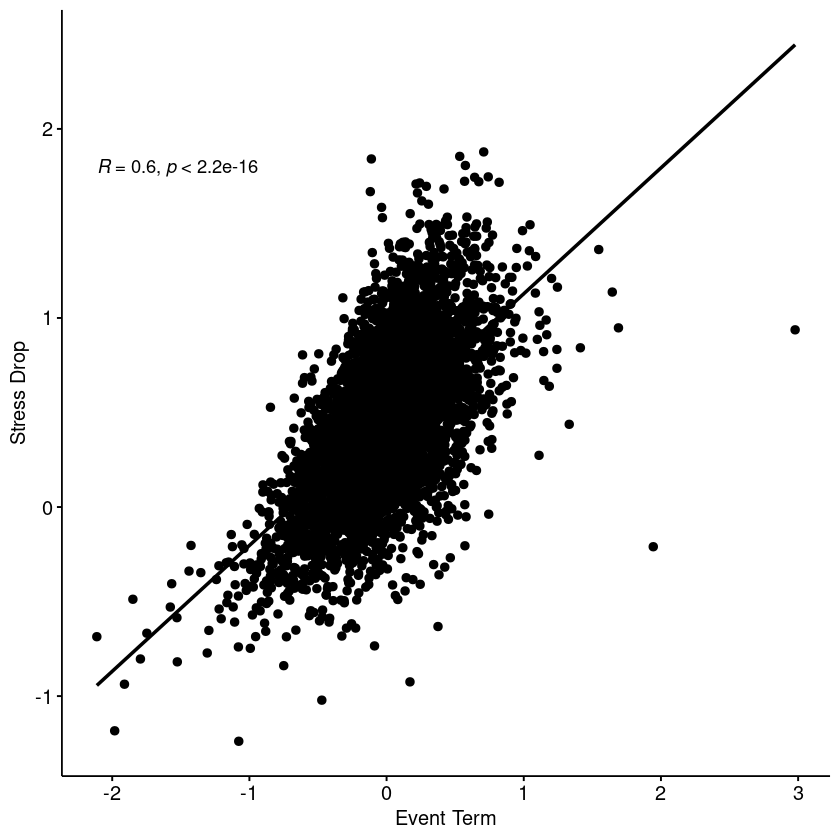

In [11]:
df_plot<-data.frame(dET_1,sig)
res <- cor.test(df_plot$dET_1, df_plot$sig, 
                method = "pearson")
res
ggscatter(df_plot, x = "dET_1", y = "sig", 
              add = "reg.line", conf.int = FALSE, 
              cor.coef = TRUE, cor.method = "pearson",
              xlab = "Event Term", ylab = "Stress Drop")

# used a more sophisicated ergodic ground motion model
## equation-1 in Sahakian et al., 2018
## f_erg + dE + dW

In [12]:
fit_inla2 <-inla(y ~ 1 + M + M2 + lnRef + R + lnvs +
                   f(eqid, model="iid"), data=inladata,
                 num.threads = 1,quantiles = c(0.05,0.5,0.95),
                 control.predictor=list(compute=TRUE),verbose = TRUE)

summary(fit_inla2)


Call:
   c("inla(formula = y ~ 1 + M + M2 + lnRef + R + lnvs + f(eqid, model = 
   \"iid\"), ", " data = inladata, quantiles = c(0.05, 0.5, 0.95), verbose 
   = TRUE, ", " control.predictor = list(compute = TRUE), num.threads = 
   1)" ) 
Time used:
    Pre = 0.477, Running = 473, Post = 6.27, Total = 480 
Fixed effects:
               mean    sd 0.05quant 0.5quant 0.95quant    mode kld
(Intercept) -34.124 3.095   -39.225  -34.121   -29.031 -34.115   0
M             7.128 0.551     6.221    7.127     8.036   7.126   0
M2            0.381 0.048     0.302    0.381     0.459   0.381   0
lnRef        -2.537 0.012    -2.556   -2.537    -2.518  -2.537   0
R             0.029 0.000     0.028    0.029     0.029   0.029   0
lnvs         -0.103 0.007    -0.115   -0.103    -0.092  -0.103   0

Random effects:
  Name	  Model
    eqid IID model

Model hyperparameters:
                                        mean    sd 0.05quant 0.5quant 0.95quant
Precision for the Gaussian observations 1.56 0.006  

In [13]:
dB_2<-fit_inla2$summary.random$eqid

dET_2 <- dB_2$`0.5quant`

event_term_2<-matrix(nrow=nrow(inladata),ncol=1)

for (i in 1:nrow(inladata)){
  event_term_2[i,]<-dET_2[eq_id[i]]
}

pred_fixed_2<-fit_inla2$summary.fitted.values$mean-event_term_2

tot_2<-df_flatfile$PGA - pred_fixed_2


	Pearson's product-moment correlation

data:  df_plot$dET_2 and df_plot$sig
t = 51.421, df = 5294, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5588973 0.5948302
sample estimates:
     cor 
0.577143 


`geom_smooth()` using formula 'y ~ x'



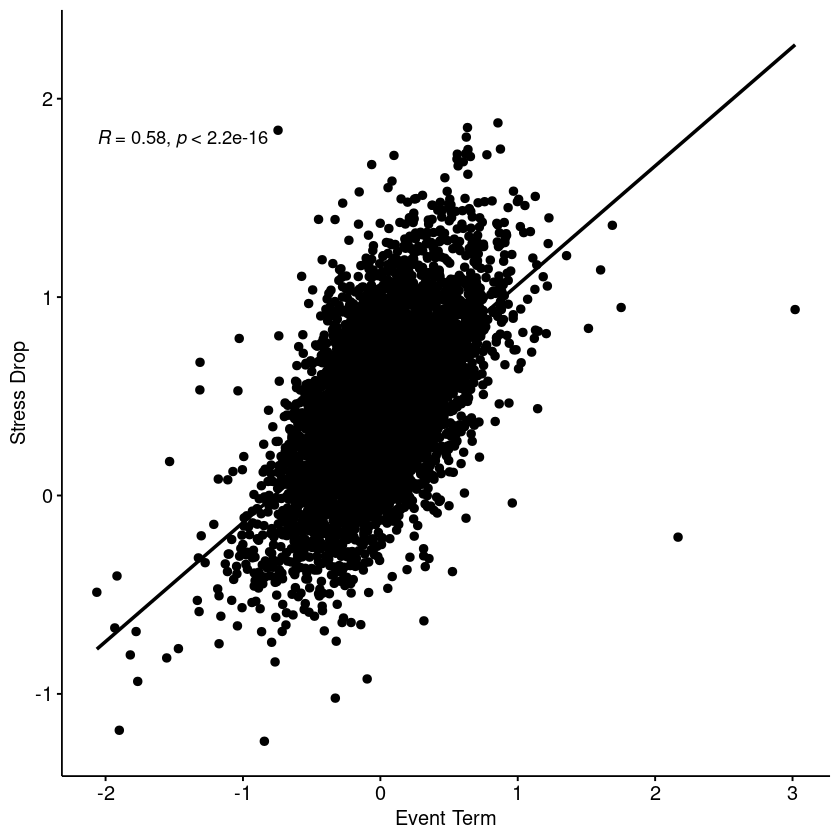

In [14]:
df_plot<-data.frame(dET_2,sig)
res <- cor.test(df_plot$dET_2, df_plot$sig, 
                method = "pearson")
res
ggscatter(df_plot, x = "dET_2", y = "sig", 
              add = "reg.line", conf.int = FALSE, 
              cor.coef = TRUE, cor.method = "pearson",
              xlab = "Event Term", ylab = "Stress Drop")

# used a more sophisicated ergodic ground motion model
## equation-1 in Sahakian et al., 2018
## f_erg + dE + dS + dW

In [15]:
fit_inla3 <-inla(y ~ 1 + M + M2 + lnRef + R + lnvs +
                   f(eqid, model="iid") + f(stid, model="iid"), data=inladata,
                 num.threads = 1,quantiles = c(0.05,0.5,0.95),
                 control.predictor=list(compute=TRUE),verbose = TRUE)

summary(fit_inla3)


Call:
   c("inla(formula = y ~ 1 + M + M2 + lnRef + R + lnvs + f(eqid, model = 
   \"iid\") + ", " f(stid, model = \"iid\"), data = inladata, quantiles = 
   c(0.05, ", " 0.5, 0.95), verbose = TRUE, control.predictor = 
   list(compute = TRUE), ", " num.threads = 1)") 
Time used:
    Pre = 0.52, Running = 232, Post = 6.96, Total = 239 
Fixed effects:
               mean    sd 0.05quant 0.5quant 0.95quant    mode kld
(Intercept) -35.792 2.652   -40.161  -35.790   -31.426 -35.788   0
M             7.465 0.472     6.687    7.464     8.243   7.464   0
M2            0.418 0.041     0.351    0.418     0.486   0.418   0
lnRef        -2.612 0.009    -2.626   -2.612    -2.598  -2.612   0
R             0.027 0.000     0.027    0.027     0.028   0.027   0
lnvs          0.060 0.112    -0.125    0.060     0.245   0.060   0

Random effects:
  Name	  Model
    eqid IID model
   stid IID model

Model hyperparameters:
                                        mean    sd 0.05quant 0.5quant 0.95quant
Prec

In [16]:
dB_3<-fit_inla3$summary.random$eqid
dS_3<-fit_inla3$summary.random$stid

dET_3 <- dB_3$`0.5quant`
dST_3 <- dS_3$`0.5quant`

event_term_3<-matrix(nrow=nrow(inladata),ncol=1)
station_term_3<-matrix(nrow=nrow(inladata),ncol=1)

for (i in 1:nrow(inladata)){
  event_term_3[i,]<-dET_3[eq_id[i]]
  station_term_3[i,]<-dST_3[sta_id[i]]
}

pred_fixed_3<-fit_inla3$summary.fitted.values$mean-event_term_3-station_term_3

tot_3<-df_flatfile$PGA - pred_fixed_3


	Pearson's product-moment correlation

data:  df_plot$dET_3 and df_plot$sig
t = 58.846, df = 5294, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6122815 0.6448563
sample estimates:
      cor 
0.6288448 


`geom_smooth()` using formula 'y ~ x'



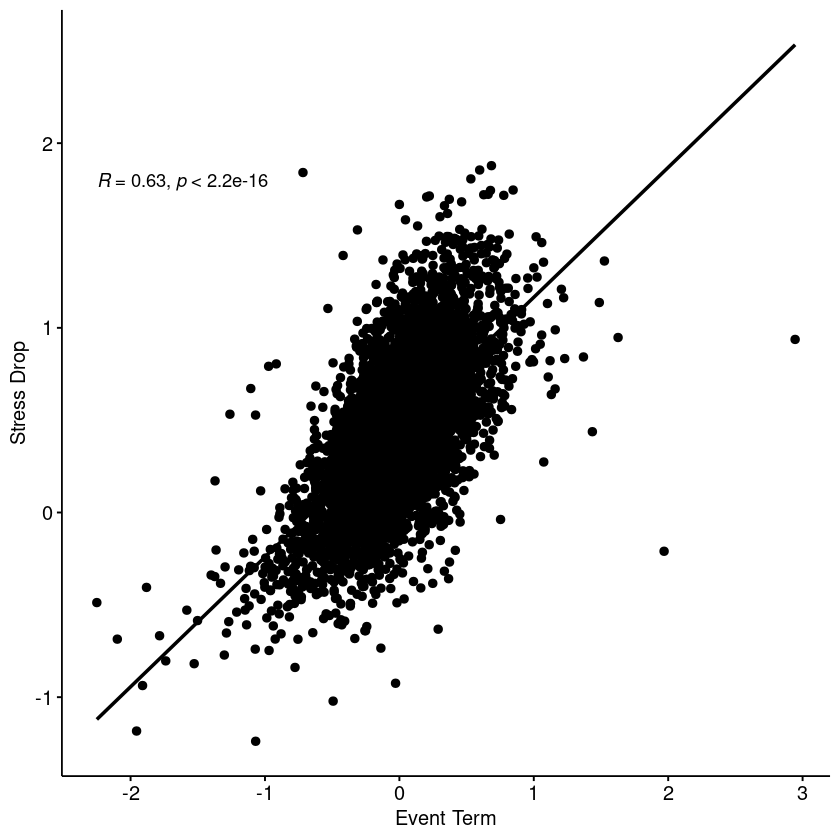

In [17]:
df_plot<-data.frame(dET_3,sig)
res <- cor.test(df_plot$dET_3, df_plot$sig, 
                method = "pearson")
res
ggscatter(df_plot, x = "dET_3", y = "sig", 
              add = "reg.line", conf.int = FALSE, 
              cor.coef = TRUE, cor.method = "pearson",
              xlab = "Event Term", ylab = "Stress Drop")

# Comparison of total residauls

In [18]:
vs <- exp(lnvs)*Vref
df_plot=data.frame(M,R,vs,y,eqid,stid,pred_trugman,tot_trugman,pred_fixed_0,tot_0,pred_fixed_1,tot_1,pred_fixed_2,tot_2)

mapping: y = ~tot_3 
geom_point: na.rm = FALSE
stat_identity: na.rm = FALSE
position_identity 

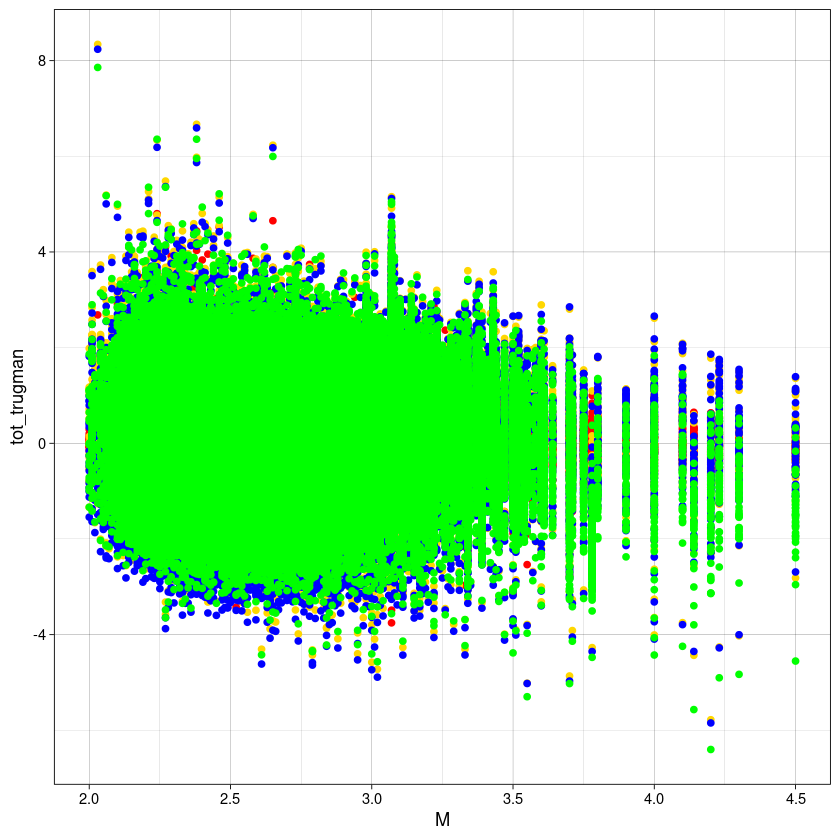

In [19]:
p<-ggplot(df_plot,aes(x = M))+
  geom_point(aes(y = tot_trugman), colour = "red") + 
  geom_point(aes(y = tot_0), colour = "gold") + 
  geom_point(aes(y = tot_1), colour = "blue") + 
  geom_point(aes(y = tot_2), colour = "green")
  geom_point(aes(y = tot_3), colour = "cyan")

p

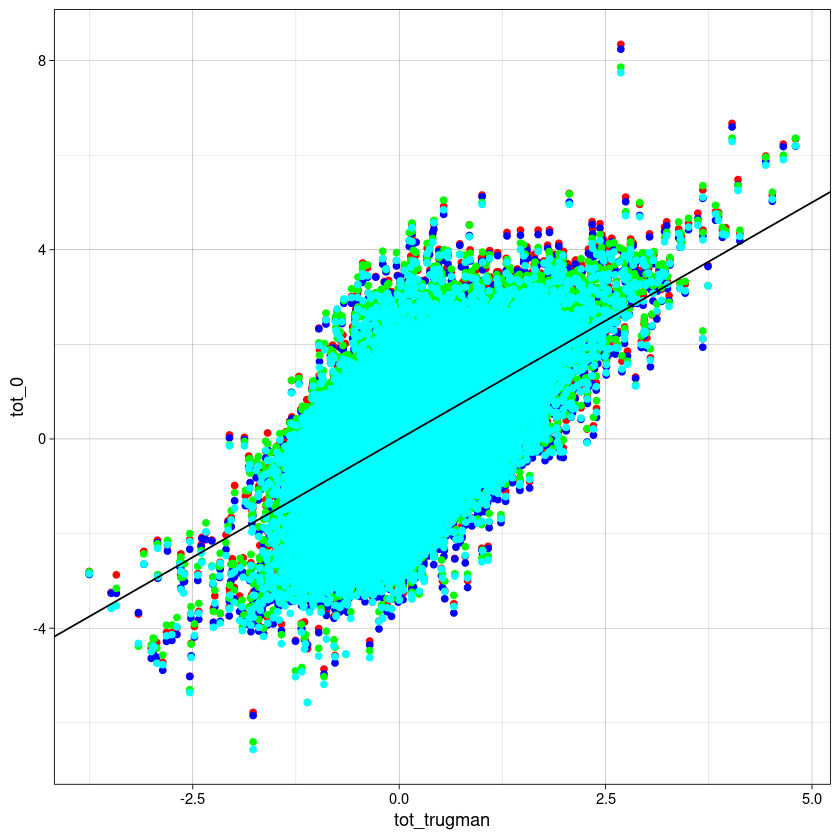

In [20]:
p<-ggplot(df_plot,aes(x = tot_trugman))+
  geom_point(aes(y = tot_0), colour = "red") + 
  geom_point(aes(y = tot_1), colour = "blue") + 
  geom_point(aes(y = tot_2), colour = "green") +
  geom_point(aes(y = tot_3), colour = "cyan") +
  geom_abline(intercept = 0,slope = 1,color='black')
p


In [21]:
newcsv <- data.frame(pred_fixed_0,event_term_0,tot_0,pred_fixed_1,event_term_1,station_term_1,tot_1,pred_fixed_2,event_term_2,tot_2,pred_fixed_3,event_term_3,station_term_3,tot_3)
outcsv <- cbind(df_flatfile,newcsv)
write.csv(outcsv,"data/compile_all.csv", row.names = FALSE)